In [1]:
!pip install ultralytics -q

In [2]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import Video, display
import subprocess
import shutil

In [5]:
# Load image level csv file
# extra_df = pd.read_csv('/kaggle/input/pseudolabel/train_pseudo_label1280.csv')
extra_df = pd.read_csv('/kaggle/input/smartathon/train.csv')
extra_df.columns = ['ObjectClassId', 'path', 'ObjectClassName', 'Right', 'Left', 'Bottom', 'Top']
extra_df["Right"] = extra_df["Right"].apply(lambda x: int(x*2))
extra_df["Left"] = extra_df["Left"].apply(lambda x: int(x*2))
extra_df["Top"] = extra_df["Top"].apply(lambda x: int(x*2))
extra_df["Bottom"] = extra_df["Bottom"].apply(lambda x: int(x*2))
extra_df["Width"] = extra_df["Right"] - extra_df["Left"]
extra_df["Height"] = extra_df["Bottom"] - extra_df["Top"]

extra_df = extra_df[['ObjectClassName', 'ObjectClassId', 'Left', 'Top', 'Right',
       'Bottom', 'Width', 'Height', 'path']]

extra_df["Right"] = extra_df["Right"] - extra_df["Width"]//4
extra_df["Left"] = extra_df["Left"] + extra_df["Width"]//4
extra_df["Top"] = extra_df["Top"] + extra_df["Height"]//4
extra_df["Bottom"] = extra_df["Bottom"] - extra_df["Height"]//4

extra_df = extra_df[extra_df["ObjectClassName"]=="POTHOLES"]

print('Number of ground truth bounding boxes: ', len(extra_df))

# Number of unique labels
label_to_id = {label: i for i, label in enumerate(extra_df.ObjectClassName.unique())}
print('Unique labels: ', label_to_id)

# Group together bbox coordinates belonging to the same image. 
# key is the name of the image, value is a dataframe with label and bbox coordinates. 
image_bbox_label = {} 
for image, df in extra_df.groupby('path'): 
    image_bbox_label[image] = df.reset_index(drop=True)

# # Visualize
extra_df.head()

Number of ground truth bounding boxes:  2625
Unique labels:  {'POTHOLES': 0}


,ObjectClassName,ObjectClassId,Left,Top,Right,Bottom,Width,Height,path
9,POTHOLES,2.0,1380,630,1582,754,402,248,e1f3026bc4b1689d81f03e92e9043c2b.jpg
14,POTHOLES,2.0,480,509,650,569,338,118,f05cd6411a3509a5ddc9d9a52536df01.jpg
34,POTHOLES,2.0,940,779,1174,1045,466,532,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg
35,POTHOLES,2.0,1265,791,1465,1023,398,462,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg
39,POTHOLES,2.0,1017,731,1537,945,1038,428,3fe43374bd1816998ad96704da640c60.jpg


In [7]:
os.makedirs('tmp/nfl_extra/images/all', exist_ok=True)
    
base = "/kaggle/input/smartathon/images"
os.listdir(base)
for file in extra_df["path"]:
    copyfile(base+"/"+file, f'tmp/nfl_extra/images/all/{file}')

In [48]:
# os.listdir("tmp/nfl_extra/images/all")

In [49]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

In [51]:
base = "tmp/nfl_extra/images/all/"
results = []
for file in os.listdir(base):
        results.append(model.predict(base+file, save=False, return_outputs=True))

Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients
Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients
Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients
Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients
Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients
Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients
Ultralytics YOLOv8.0.5 🚀 Python-3.7.12 torch-1

In [65]:
base = "tmp/nfl_extra/images/all/"
for result, path in zip(results, os.listdir(base)):
    img = cv2.imread(base+path)
    for r in result:
        if len(r.keys()):
            for bbox in r["det"]:
                cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255,255,255), -1)
    cv2.imwrite(base+path, img)

image 1/1 /kaggle/working/tmp/nfl_extra/images/all/3198c9cf4e8cb4bdf951a27cfbfdc9ed.jpg: 384x640 3 cars, 9.7ms
Speed: 0.4ms pre-process, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 /kaggle/working/tmp/nfl_extra/images/all/6facfbb68ec69bbbfd355b7754b03005.jpg: 384x640 10.5ms
Speed: 0.4ms pre-process, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 /kaggle/working/tmp/nfl_extra/images/all/9242483a80e7abe25eefefbb4150adb8.jpg: 384x640 4 persons, 9 cars, 1 truck, 9.7ms
Speed: 0.3ms pre-process, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 /kaggle/working/tmp/nfl_extra/images/all/1a4cb110b742dfbafcdf927fba3b502b.jpg: 384x640 1 car, 9.2ms
Speed: 0.3ms pre-process, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 /kaggle/working/tmp/nfl_extra/images/all/261cea67d82b0d464320cc381de66fbf.jpg: 384x640 3 cars, 9.3ms
Speed: 0.3ms pre-process, 9.3ms inference, 1

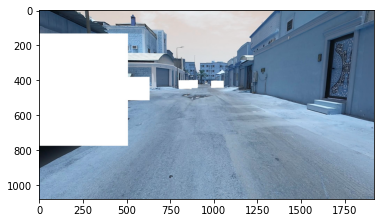

In [70]:
plt.imshow(cv2.imread(base+"a8983d081ee7ac57762f4157bd76b1c6.jpg"))

In [71]:
i = extra_df["path"][35]
img = cv2.imread("tmp/nfl_extra/images/all/" + i)
group = extra_df.groupby("path")

group.get_group(i)



,ObjectClassName,ObjectClassId,Left,Top,Right,Bottom,Width,Height,path
34,POTHOLES,2.0,940,779,1174,1045,466,532,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg
35,POTHOLES,2.0,1265,791,1465,1023,398,462,f6e45cdb24e1bfc3214308ff1ddd2de2.jpg


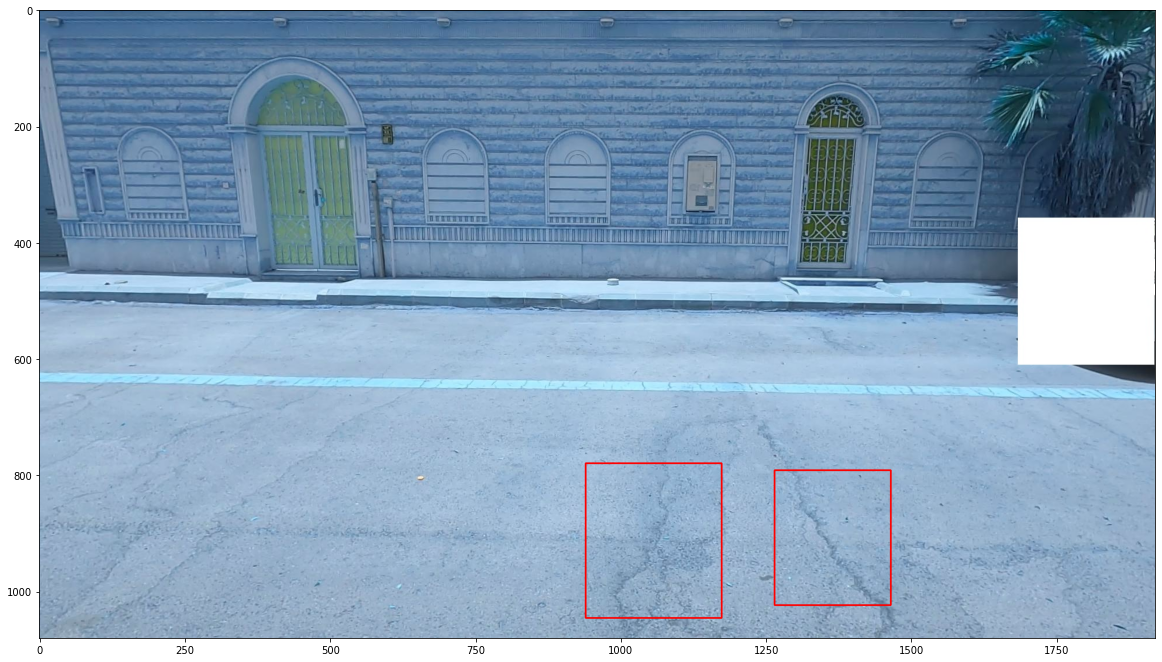

In [72]:
for idx, detect in group.get_group(i).iterrows():
    img = cv2.rectangle(img, (detect["Left"], detect["Top"]), (detect["Right"], detect["Bottom"]), (255,0,0), (2))
    

plt.figure(figsize=(20,40))
plt.imshow(img)

In [73]:
# Create train and validation split.
train_names, valid_names = train_test_split(list(image_bbox_label), test_size=0.1)
print(f'Size of dataset: {len(image_bbox_label)},\
       training images: {len(train_names)},\
       validation images: {len(valid_names)}')

Size of dataset: 1136,       training images: 1022,       validation images: 114


In [74]:
for k in valid_names:
    if k.__contains__("bjh"):
        print("no")

In [76]:
TRAIN_PATH = 'tmp/nfl_extra/images/all'

In [77]:
os.makedirs('tmp/nfl_extra/images/train', exist_ok=True)
os.makedirs('tmp/nfl_extra/images/valid', exist_ok=True)

os.makedirs('tmp/nfl_extra/labels/train', exist_ok=True)
os.makedirs('tmp/nfl_extra/labels/valid', exist_ok=True)



# Move the images to relevant split folder.
for img_name in tqdm(train_names):
    img_name=img_name.split('/')[-1]
    copyfile(f'{TRAIN_PATH}/{img_name}',f'tmp/nfl_extra/images/train/{img_name}')

for img_name in tqdm(valid_names):
    img_name=img_name.split('/')[-1]
    copyfile(f'{TRAIN_PATH}/{img_name}',f'tmp/nfl_extra/images/valid/{img_name}')

100%|██████████| 114/114 [00:00<00:00, 1777.90it/s]


In [82]:
import yaml

data_yaml = dict(
    train = 'tmp/nfl_extra/images/train',
    val = 'tmp/nfl_extra/images/valid',
    nc = len(list(extra_df.ObjectClassName.unique())),
    names = list(extra_df.ObjectClassName.unique())
)

# Note that the file is created in the yolov5/data/ directory.
with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat data.yaml

{names: [POTHOLES], nc: 1, train: tmp/nfl_extra/images/train, val: tmp/nfl_extra/images/valid}


In [83]:
def get_yolo_format_bbox(img_w, img_h, box):
    """
    Convert the bounding boxes in YOLO format.
    
    Input:
    img_w - Original/Scaled image width
    img_h - Original/Scaled image height
    box - Bounding box coordinates in the format, "left, width, top, height"
    
    Output:
    Return YOLO formatted bounding box coordinates, "x_center y_center width height".
    """
    w = box.Width # width 
    h = box.Height # height
    xc = box.Left + int(np.round(w/2)) # xmin + width/2
    yc = box.Top + int(np.round(h/2)) # ymin + height/2

    return [xc/img_w, yc/img_h, w/img_w, h/img_h] # x_center y_center width height
    
# Iterate over each image and write the labels and bbox coordinates to a .txt file. 

for img_name, df in tqdm(image_bbox_label.items()):
    # open image file to get the height and width 
    file=img_name
    img_name=img_name.split('/')[-1]
    img = cv2.imread("tmp/nfl_extra/images/all/"+img_name)
    height, width, _ = img.shape 
    # iterate over bounding box df
    bboxes = []
    for i in range(len(df)):
        # get a row
        box = df.loc[i]
        # get bbox in YOLO format
        box = get_yolo_format_bbox(width, height, box)
        bboxes.append(box)
    
    if file in train_names:
        img_name=img_name.split('/')[-1]
        img_name = img_name[:-4]
        file_name = f'tmp/nfl_extra/labels/train/{img_name}.txt'
    elif file in valid_names:
        img_name=img_name.split('/')[-1]
        img_name = img_name[:-4]
        file_name = f'tmp/nfl_extra/labels/valid/{img_name}.txt'  
    with open(file_name, 'w') as f:
        for i, bbox in enumerate(bboxes):
            label = label_to_id[df.loc[i].ObjectClassName]
            bbox = [label]+bbox
            bbox = [str(i) for i in bbox]
            bbox = ' '.join(bbox)
            f.write(bbox)
            f.write('\n')

100%|██████████| 1136/1136 [00:29<00:00, 38.92it/s]


In [ ]:
model = YOLO("yolov8n.yaml")  # build a new model from scratch

# Use the model
results = model.train(data="data.yaml", epochs=13)  # train the model
results = model.val()  # evaluate model performance on the validation set


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics